form https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/3_regularization.ipynb

Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from six.moves import cPickle as pickle

%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
data_root = 'notMNIST/'
pickle_file = 'notMNIST.pickle'
path = os.path.join(data_root, pickle_file)


with open(path, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [5]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

# Regularization in logistic model

In [6]:
# see code from 2_fullyconnected.ipynb
batch_size = 128
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    beta = tf.placeholder(tf.float32)  # regularization term

    logits = tf.matmul(tf_train_dataset, weights) + biases
    regularization = beta * (tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases))

    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    ) + regularization

    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [7]:
num_steps = 1000

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta:0.0005}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 200 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            print("")
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 16.174650
Minibatch accuracy: 8.6%
Validation accuracy: 14.2%

Minibatch loss at step 200: 3.413007
Minibatch accuracy: 67.2%
Validation accuracy: 72.0%

Minibatch loss at step 400: 2.527621
Minibatch accuracy: 72.7%
Validation accuracy: 75.0%

Minibatch loss at step 600: 2.449730
Minibatch accuracy: 75.0%
Validation accuracy: 76.1%

Minibatch loss at step 800: 1.844812
Minibatch accuracy: 79.7%
Validation accuracy: 76.7%

Test accuracy: 84.5%


In [8]:
batch_size = 128
beta_vals = np.logspace(-4, 0, num = 20)
validation_acc = []

for beta_val in beta_vals:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
    
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : beta_val} 
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
            
        validation_acc.append(accuracy(test_prediction.eval(), test_labels))

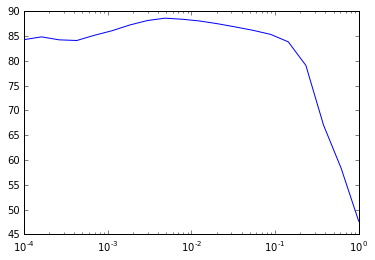

In [9]:
def plot_beta(beta_vals, validation_acc):
    plt.semilogx(beta_vals, validation_acc)
    plt.show()

plot_beta(beta_vals, validation_acc)

# Regularization in neural model with a hidden layer

In [10]:
batch_size = 128
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)

    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes]))
    
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))

    # Regularization
    regularization = beta * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(biases_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(biases_2))
    
    # Training computation.
    def compute(input_data):       
        layer_1 = tf.nn.relu(tf.matmul(input_data, weights_1) + biases_1)
        return tf.matmul(layer_1, weights_2) + biases_2
    
    logits = compute(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + regularization
    

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(compute(tf_valid_dataset))
    test_prediction = tf.nn.softmax(compute(tf_test_dataset))

In [11]:
num_steps = 100

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta:0.0005}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 200 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            print("")
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 495.111389
Minibatch accuracy: 10.9%
Validation accuracy: 38.9%

Test accuracy: 85.0%


In [12]:
batch_size = 128
beta_vals = np.logspace(-4, 0, num = 20)
validation_acc = []

for beta_val in beta_vals:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
    
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : beta_val} 
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
            
        validation_acc.append(accuracy(test_prediction.eval(), test_labels))

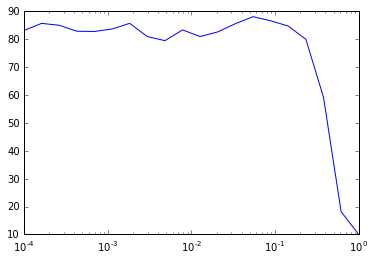

In [13]:
plot_beta(beta_vals, validation_acc)

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [14]:
num_steps = 11

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 0.0005}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 10 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            print("")
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 576.509521
Minibatch accuracy: 11.7%
Validation accuracy: 23.5%

Minibatch loss at step 10: 230.903320
Minibatch accuracy: 75.0%
Validation accuracy: 70.6%

Test accuracy: 78.4%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [15]:
batch_size = 128
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    dropout_proba = tf.placeholder(tf.float32)
    
    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes]))
    
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))

    layer_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    layer_1_drop = tf.nn.dropout(layer_1, dropout_proba)
    logits = tf.matmul(layer_1_drop, weights_2) + biases_2
    
     
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)

    # Testing and validation computation.
    def compute(input_data):       
        layer_1 = tf.nn.relu(tf.matmul(input_data, weights_1) + biases_1)
        return tf.matmul(layer_1, weights_2) + biases_2
    
    valid_prediction = tf.nn.softmax(compute(tf_valid_dataset))
    test_prediction = tf.nn.softmax(compute(tf_test_dataset))

In [16]:
num_steps = 1001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, dropout_proba : 0.5}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 200 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            print("")
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 559.223633
Minibatch accuracy: 7.8%
Validation accuracy: 34.6%

Minibatch loss at step 200: 49.120789
Minibatch accuracy: 69.5%
Validation accuracy: 80.1%

Minibatch loss at step 400: 40.094555
Minibatch accuracy: 72.7%
Validation accuracy: 80.9%

Minibatch loss at step 600: 29.943146
Minibatch accuracy: 77.3%
Validation accuracy: 80.5%

Minibatch loss at step 800: 24.538130
Minibatch accuracy: 75.8%
Validation accuracy: 79.2%

Minibatch loss at step 1000: 9.512255
Minibatch accuracy: 78.9%
Validation accuracy: 79.8%

Test accuracy: 87.0%


In [17]:
num_steps = 21

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, dropout_proba : 0.5}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 10 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            print("")
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 417.114349
Minibatch accuracy: 11.7%
Validation accuracy: 33.1%

Minibatch loss at step 10: 261.704346
Minibatch accuracy: 60.9%
Validation accuracy: 69.1%

Minibatch loss at step 20: 88.264717
Minibatch accuracy: 75.8%
Validation accuracy: 78.1%

Test accuracy: 85.4%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [18]:
batch_size = 128
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    dropout_proba = tf.placeholder(tf.float32)
    
    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes], stddev=0.1))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.1))
    biases_2 = tf.Variable(tf.zeros([hidden_nodes]))
    weights_3 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.1))
    biases_3 = tf.Variable(tf.zeros([hidden_nodes]))
    weights_4 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels], stddev=0.1))
    biases_4 = tf.Variable(tf.zeros([num_labels]))


    layer_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    layer_1 = tf.nn.dropout(layer_1, dropout_proba)

    layer_2 = tf.nn.relu(tf.matmul(layer_1, weights_2) + biases_2)
    layer_2 = tf.nn.dropout(layer_2, dropout_proba)
    
    layer_3 = tf.nn.relu(tf.matmul(layer_2, weights_3) + biases_3)
    layer_3 = tf.nn.dropout(layer_3, dropout_proba)
    
    logits = tf.matmul(layer_3, weights_4) + biases_4
     
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    # global_step = tf.Variable(0)
    # learning_rate = tf.train.exponential_decay(0.2, global_step, 10000, 0.96)
    # optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, step, 100000, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)

    # Testing and validation computation.
    def compute(input_data):       
        layer_1 = tf.nn.relu(tf.matmul(input_data, weights_1) + biases_1)
        layer_2 = tf.nn.relu(tf.matmul(layer_1, weights_2) + biases_2)
        layer_3 = tf.nn.relu(tf.matmul(layer_2, weights_3) + biases_3)
        return tf.nn.relu(tf.matmul(layer_3, weights_4) + biases_4)
    
    valid_prediction = tf.nn.softmax(compute(tf_valid_dataset))
    test_prediction = tf.nn.softmax(compute(tf_test_dataset))

In [19]:
num_steps = 8001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, dropout_proba : 0.5}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            print("")
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 40.900890
Minibatch accuracy: 14.1%
Validation accuracy: 18.0%

Minibatch loss at step 500: 0.873099
Minibatch accuracy: 76.6%
Validation accuracy: 80.1%

Minibatch loss at step 1000: 0.781923
Minibatch accuracy: 82.8%
Validation accuracy: 81.0%

Minibatch loss at step 1500: 0.720385
Minibatch accuracy: 80.5%
Validation accuracy: 81.9%

Minibatch loss at step 2000: 0.624431
Minibatch accuracy: 81.2%
Validation accuracy: 82.4%

Minibatch loss at step 2500: 0.609813
Minibatch accuracy: 80.5%
Validation accuracy: 82.8%

Minibatch loss at step 3000: 0.729615
Minibatch accuracy: 75.0%
Validation accuracy: 83.1%

Minibatch loss at step 3500: 0.935477
Minibatch accuracy: 75.8%
Validation accuracy: 83.3%

Minibatch loss at step 4000: 0.709962
Minibatch accuracy: 80.5%
Validation accuracy: 83.6%

Minibatch loss at step 4500: 0.691989
Minibatch accuracy: 78.1%
Validation accuracy: 83.6%

Minibatch loss at step 5000: 0.538987
Minibatch accuracy: 82.8%
Validat